In [1]:
import os
from dotenv import find_dotenv, load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv(find_dotenv())

key = os.environ["MODELSCOPE_TOKEN"]
llm = ChatOpenAI(
    base_url="https://api-inference.modelscope.cn/v1",
    api_key=key,
    model="deepseek-ai/DeepSeek-V3.1",
    temperature=0,
)

llm_think = llm.bind(
    extra_body={
        "enable_thinking": True
    }
)

## 数据模型

In [2]:
from typing import TypedDict
from pydantic import BaseModel, Field
# from typing import List  # 类型提示：List[T]。在 Python 3.9+ 可用内置 list[T] 替代

# =============================================================================
# 数据模型 (Pydantic + TypedDict)
# -----------------------------------------------------------------------------
# Pydantic 模型为 Analyst 设定和集合定义了结构化数据。
# TypedDicts 表示在 LangGraph 节点间传递的状态对象。
# =============================================================================

class Analyst(BaseModel):
    # 表示单个“分析员”的结构（Pydantic 模型），包含身份与描述信息
    affiliation: str = Field(
        description="分析员的主要所属机构。",  # 字段描述：用于文档/Schema（不会改变校验逻辑）
    )
    name: str = Field(
        description="分析员姓名。"
    )
    role: str = Field(
        description="在该主题语境下的角色与职责。",
    )
    description: str = Field(
        description="分析员的关注点、担忧与动机描述。",
    )

    @property
    def persona(self) -> str:
        # 只读属性：将分析员关键信息拼接为多行字符串，便于人读或作为提示词
        return (
            f"姓名: {self.name}\n"
            f"角色: {self.role}\n"
            f"所属机构: {self.affiliation}\n"
            f"描述: {self.description}\n"
        )

class Perspectives(BaseModel):
    # 表示“多个分析员的集合”的模型（容器）；由 PydanticOutputParser 使用
    analysts: list[Analyst] = Field(
        description="包含分析员及其角色与所属机构的完整列表。",
    )

class GenerateAnalystsState(TypedDict):
    # “生成分析员”子图使用的状态
    # 注意：默认 total=True，所以下面所有键都是必填项（静态类型检查用，运行时不校验）
    topic: str  # 研究主题
    max_analysts: int  # 分析员数量上限
    human_analyst_feedback: str  # 人类分析员的反馈
    analysts: list[Analyst]  # 已生成的分析员列表（元素为 Pydantic 模型实例）

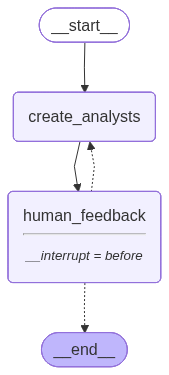

In [7]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.messages import SystemMessage, HumanMessage

# =============================================================================
# 分析员生成
# -----------------------------------------------------------------------------
# 此阶段提示 LLM 以严格的 JSON 格式生成一个分析员人物设定列表，
# 然后使用 Pydantic 解析为结构化数据。一个人工反馈节点允许
# 在最终确定前进行外部编辑
# =============================================================================

analyst_instructions = """你将负责创建一组 AI 分析员人物设定（personas）。请严格遵循以下指示：

1. 首先，审阅研究主题：
{topic}

2. 查看（可选的）用于指导分析员创建的编辑反馈：
{human_analyst_feedback}

3. 基于上述文档和/或反馈，确定最有趣的主题。

4. 选出排名靠前的 {max_analysts} 个主题。

5. 为每个主题分配一名分析员。

6. 输出语言使用中文。"""

def create_analysts(state: GenerateAnalystsState):
    """
    使用 LLM 生成分析员人物设定，并通过 Pydantic 进行解析。

    流程：
    - 从 PydanticOutputParser 构建格式指令（严格的 JSON schema）。
    - 组合一个带有约束（仅 JSON，无 markdown 代码块）的系统消息。
    - 调用 LLM 并解析响应；在状态中返回结构化的分析员。
    """
    topic = state['topic']
    max_analysts = state['max_analysts']
    human_analyst_feedback = state.get('human_analyst_feedback', '')
    # 配置一个 Pydantic 解析器以强制执行输出模式 (Perspectives)
    parser = PydanticOutputParser(pydantic_object=Perspectives)

    format_instructions = parser.get_format_instructions()
    # ModelScope deepseek3.1 兼容 Open AI 接口的 api 不支持 response_format=json_schema 因此需要 将指令与解析器格式规则和一个严格的“仅 JSON”通知结合起来。
    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback,
        max_analysts=max_analysts
    ) + (
        "\n\n严格的输出要求：\n"
        f"{format_instructions}\n"
        "重要：只输出合法 JSON（不要 Markdown、不要多余文字、不要使用 ``` 代码块）。"
    )

    resp = llm.invoke([
        SystemMessage(content=system_message),
        HumanMessage(content="请生成这组分析员")
    ])
    # 将 JSON 响应解析为 Pydantic 模型
    text = resp.content.strip() # 处理首尾空白符
    perspectives = parser.parse(text)

    return {"analysts": perspectives.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ 人工反馈节点（no-op），配合 interrupt_before 在此处中断等待人工输入
        这里有意不做任何处理，真实的“反馈”由外部在中断点插入到 state 中
    """
    pass

def should_continue(state: GenerateAnalystsState):
    """
    决定是循环回去重新创建分析员（如果存在反馈），
    还是结束子图（如果没有反馈）。
    """
    human_analyst_feedback = state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"

    return END

# 构建工作流图：指定状态类型
builder = StateGraph(GenerateAnalystsState)

# 注册节点
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)

# 配置静态边：从 START → create_analysts，再到 human_feedback
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")

# 配置条件边：从 human_feedback 出发，由 should_continue 决定去 create_analysts 或 END
builder.add_conditional_edges(
    "human_feedback",
    should_continue,
    ["create_analysts", END]
)

# 编译图
# - interrupt_before=['human_feedback']：在执行 human_feedback 之前中断，留出人工介入的时机
# - checkpointer=memory：使用内存检查点保存/恢复 state，支持多轮交互
memory = MemorySaver()
graph = builder.compile(
    interrupt_before=['human_feedback'],
    checkpointer=memory
)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [8]:
max_analysts = 3
topic = "LangGraph和LangChain的区别"
thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: 张智渊
Affiliation: 深度机器学习研究院
Role: LangGraph与LangChain架构差异分析专家
Description: 专注于分析LangGraph和LangChain在架构设计、工作流管理、状态处理等方面的核心差异，关注两种框架如何解决复杂AI应用中的状态管理和多步骤推理问题。
--------------------------------------------------
Name: 李思颖
Affiliation: AI工程化实践联盟
Role: 实际应用场景对比研究员
Description: 致力于研究LangGraph和LangChain在不同实际应用场景下的适用性和性能表现，关注开发者在具体项目中如何根据需求选择合适的框架。
--------------------------------------------------
Name: 王建明
Affiliation: 开源AI框架评测中心
Role: 生态系统与社区发展分析师
Description: 专注于分析LangGraph和LangChain的生态系统成熟度、社区活跃度、工具链完整性以及未来发展潜力，为开发者提供框架选择的长远视角。
--------------------------------------------------


In [9]:
state = graph.get_state(thread)
state.next

('human_feedback',)

In [10]:
graph.update_state(thread, {"human_analyst_feedback":
                            "邀请一位来自初创企业的人士加入，以添加创业者的视角"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f091e15-2a84-69d0-8002-7f72030ea277'}}

In [11]:
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: 张智渊
Affiliation: 深度机器学习研究院
Role: LangGraph与LangChain架构差异分析专家
Description: 专注于分析LangGraph和LangChain在架构设计、工作流管理、状态处理等方面的核心差异，关注两种框架如何解决复杂AI应用中的状态管理和多步骤推理问题。
--------------------------------------------------
Name: 李思颖
Affiliation: AI工程化实践联盟
Role: 实际应用场景对比研究员
Description: 致力于研究LangGraph和LangChain在不同实际应用场景下的适用性和性能表现，关注开发者在具体项目中如何根据需求选择合适的框架。
--------------------------------------------------
Name: 王建明
Affiliation: 开源AI框架评测中心
Role: 生态系统与社区发展分析师
Description: 专注于分析LangGraph和LangChain的生态系统成熟度、社区活跃度、工具链完整性以及未来发展潜力，为开发者提供框架选择的长远视角。
--------------------------------------------------
Name: 张伟
Affiliation: 科技创新研究院
Role: 技术架构分析师
Description: 关注LangGraph和LangChain在技术架构层面的差异，特别是LangGraph如何通过有状态多参与者工作流扩展LangChain的功能，以及两者在复杂应用开发中的适用场景和性能表现。
--------------------------------------------------
Name: 李娜
Affiliation: 人工智能应用实验室
Role: 应用场景研究员
Description: 专注于LangGraph和LangChain在实际应用中的使用案例，研究LangGraph的有状态工作流如何解决LangChain在复杂任务处理中的局限性，以及两者在不同行业应用中的优势和挑战。
--------------------------------------------------
Na

In [12]:
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f091e16-feef-6b22-8004-c0db42e8c5a0'}}

In [16]:
print("最终确认的角色:")
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50)

最终确认的角色:
Name: 张伟
Affiliation: 科技创新研究院
Role: 技术架构分析师
Description: 关注LangGraph和LangChain在技术架构层面的差异，特别是LangGraph如何通过有状态多参与者工作流扩展LangChain的功能，以及两者在复杂应用开发中的适用场景和性能表现。
--------------------------------------------------
Name: 李娜
Affiliation: 人工智能应用实验室
Role: 应用场景研究员
Description: 专注于LangGraph和LangChain在实际应用中的使用案例，研究LangGraph的有状态工作流如何解决LangChain在复杂任务处理中的局限性，以及两者在不同行业应用中的优势和挑战。
--------------------------------------------------
Name: 王强
Affiliation: 智能初创企业
Role: 创业者与技术决策者
Description: 从创业者的视角评估LangGraph和LangChain的技术选型，关注开发效率、可扩展性、社区支持以及长期维护成本，旨在为初创企业选择最适合的AI应用开发框架。
--------------------------------------------------


## 访谈子图

In [17]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

# =============================================================================
# 访谈子图 (分析员 ↔ 专家)
# -----------------------------------------------------------------------------
# 这个子图执行一个固定轮次的访谈循环：
# - “分析员”每轮提出一个问题（LLM 生成问题内容）。
# - 一个搜索步骤将最后一个问题转化为一个简洁的查询（通过 LLM），并
#   从 Tavily 和 Google 获取文档。
# - “专家”严格根据检索到的上下文进行回答，并附带引文。
# - 这个过程重复进行，直到问完 max_num_turns 个问题。
# - 问答结束后，保存对话并撰写一个章节备忘录。
# =============================================================================

class InterviewState(MessagesState):
    max_num_turns: int # 对话轮数
    context: Annotated[list, operator.add] # 源文档
    analyst: Analyst # 提出问题的分析师
    interview: str # 对话记录
    sections: list # 从访谈中衍生的报告章节

class SearchQuery(BaseModel):
    # 用于表示搜索查询字符串的模式（运行时并非严格要求）
    search_query: str = Field(None, description="用于检索的搜索查询")

In [18]:
question_instructions = """
你是一名采访分析师，任务是与某领域专家访谈，层层追问，深入某个特定主题。

回合规则
- 必须进行恰好 {max_turns} 轮；当前为第 {current_turn}/{max_turns} 轮。
- 每轮基于上轮回答追问，单点深入，不并列多个话题。
- 单轮输出：一个聚焦问题（必要时可附最多3个要点/指标要求），避免寒暄与总结。
- 多轮对话由 analyst 和 expert 构成，analyst是上一个提出的问题，expert 是上一个问题的答案

目标（提炼“有趣且具体”的洞见）
- 有趣：出人意料或非直觉的发现。
- 具体：包含专家给出的案例、细节或数据（数值/阈值/配置/时间/成本等）。
- 多轮对话中你将扮演 analyst 提出问题

主题与目标：{goals}

对话策略
- {intro_or_followup}
- 始终保持与提供的人设 persona 与目标一致的语气与角色。
"""

In [19]:
from typing import Any, Dict

def _invoke_stream_collect_text(chat_model, msgs) -> str:
    """
    添加一个微小的流式助手一次，到处复用
    使用流式接口从 LLM 持续接收增量内容，并拼接为一个完整字符串返回
    """
    pieces = []
    for chunk in chat_model.stream(msgs):
        if getattr(chunk, "content", ""):
            pieces.append(chunk.content)
    return "".join(pieces)

def generate_question(state: Dict[str, Any]):
    """
    根据轮次计数和人物设定生成分析员的下一个问题。
    - 通过计算之前的分析员问题数量来确定当前轮次。
    - 使用 llm_think 生成问题（启用了“思考”模式）。
    - 返回一个名为“analyst”的 HumanMessage，并附加到消息列表中。
    """
    analyst = state.get("analyst", {})
    messages = state.get("messages", [])
    max_turns = int(state.get("max_num_turns", 2))

    # 计算之前的分析员问题数量，以确定当前轮次索引。
    num_questions = sum(
        1 for m in messages
        if isinstance(m, HumanMessage) and getattr(m, "name", "") == "analyst"
    )
    current_turn = num_questions + 1

    # 根据轮次索引定制指令：介绍、追问或最后一个问题
    if current_turn == 1:
        intro_or_followup = "请先以符合你人物设定的名字进行自我介绍，然后提出你的第一个问题。"
    elif current_turn < max_turns:
        intro_or_followup = f"基于专家的回答，请提出你的第{current_turn}个深入问题。继续挖掘更多细节。"
    else:
        intro_or_followup = f"这是你的最后一个问题（第{current_turn}轮）。请提出一个总结性或最关键的问题"

    system_message = question_instructions.format(
        goals=analyst.persona,
        max_turns=max_turns,
        current_turn=current_turn,
        intro_or_followup=intro_or_followup
    )

    llm_input_messages = [SystemMessage(content=system_message)] + messages

    # 用流式 API 消费开启 thinking 的模型
    text = _invoke_stream_collect_text(llm_think, llm_input_messages)
    # “分析员”被表示为一个 HumanMessage (name="analyst")
    question_msg = HumanMessage(content=text, name="analyst")
    return {"messages": [question_msg]}

### 构建一个“分析师-专家”采访工作流的 StateGraph

In [20]:
from langchain_community.retrievers import TavilySearchAPIRetriever
tavily_retriever = TavilySearchAPIRetriever(k=3)

In [21]:
#  JSON 抽取
#  由于 魔搭平台的 openai 兼容接口  不支持 llm.with_structured_output(SearchQuery, method="json_schema") and method="function_calling"
#  ModelScope Deepseek v3.1 兼容 OpenAI 的接口存在bug 导致输出json格式时采用多严格的prompt都会输出错误的格式; 因此需要严格的验证
def _balanced_json_slice(text: str) -> str | None:
    """
    尝试从字符串中提取第一个顶层且括号平衡的 JSON 对象。

    策略：
    - 定位第一个 '{'，然后扫描字符，跟踪嵌套深度和
      是否在字符串内部（处理转义）。如果找到一个
      结构良好的 JSON 对象，则返回该切片；否则返回 None。

    为何需要：
    - 一些 LLM 会在输出前后添加额外的文本。此解析器尝试从
      嘈杂的输出中挽救一个有效的 JSON 对象。

    i: 第一个 { 的索引；如果找不到，直接返回 None。
    j: 当前扫描位置，从 i 开始。
    depth: 大括号嵌套深度计数。每见到一个 {（且不在字符串内）就 +1，每见到一个 }（且不在字符串内）就 -1。
    in_str: 是否处于双引号字符串内部。只有双引号 " 才会切换这个状态（符合 JSON 规范）。
    esc: 是否刚刚读到一个用于转义的反斜杠 \（仅在 in_str 为 True 时才有意义）。当 esc 为 True 时，下一字符会被当作被转义的普通字符处理。

    """
    i = text.find("{") # 找不到会返回 -1
    if i == -1:
        return None
    depth, j, in_str, esc = 0, i, False, False
    while j < len(text):
        ch = text[j]
        if in_str:
            if esc:
                esc = False
            elif ch == "\\":
                esc = True
            elif ch == '"':
                in_str = False
        else:
            if ch == '"':
                in_str = True
            elif ch == "{":
                depth += 1
            elif ch == "}":
                depth -= 1
                if depth == 0:
                    return text[i:j+1]
        j += 1
    return None

def _extract_query_text_strict(text: str) -> str:
    """
    从模型输出中稳健地提取 search_query 字符串。

    步骤：
    1) 统一引号
    2) 尝试提取一个平衡的 JSON 切片并用 json.loads 解析
    3) 如果失败，回退到严格匹配 "search_query": "..." 的正则表达式
    4) 最后手段：使用一个不太严格的正则表达式匹配来处理被截断的行,

    返回：
    - 提取的查询字符串，如果未找到则返回空字符串。
    """
    t = text.replace("“", '"').replace("”", '"')
    # 1) 尝试提取 JSON
    cand = _balanced_json_slice(t)
    if cand:
        try:
            obj = json.loads(cand) # 解析为 dict
            q = obj.get("search_query", "") if isinstance(obj, dict) else ""
            if isinstance(q, str) and q.strip(): # 如果 q 是非空字符串，返回 q.strip()
                return q.strip()
        except Exception:
            pass
    # 2) 严格正则（需要闭合引号）
    m = re.search(r'"search_query"\s*:\s*"([^"\\]*(?:\\.[^"\\]*)*)"', t)
    if m:
        q = m.group(1) # 得到不包含引号的内容
        q = bytes(q, "utf-8").decode("unicode_escape") # 把转义序列（如 \n、\t、\u4F60\u597D、" 等）反转义成实际字符
        return q.strip()
    # 3) 宽松兜底：容忍缺失结尾引号/花括号/换行
    m2 = re.search(r'"search_query"\s*:\s*"([^"}\n]*)', t)
    if m2:
        return m2.group(1).strip()
    return ""

def _heuristic_query_from_last_question(last_q: str) -> str:
    """
    如果json格式错误太多则使用备用方案，自行提取
    - 对字母数字和中日韩字符进行分词。
    - 去除常见的英文停用词。
    - 保留前 15 个词元以确保简洁性。
    """
    # 简单启发式：提取英文/数字/符号作为词，去停用词，最多 15 词
    tokens = re.findall(r"[A-Za-z0-9./:+#_-]+|[\u4e00-\u9fff]+", last_q)
    stop = {"the","a","an","and","or","to","of","for","in","on","with",
            "how","what","why","is","are","can","could","should","would"}
    kept = [t for t in tokens if t.lower() not in stop]
    return " ".join(kept[:15]).strip()

def _sanitize_query(q: str, limit_words: int = 15) -> str:
    """
    规范化空白字符并将查询截断到最大单词数。
    确保搜索查询保持简洁以供检索。
    """
    q = q.replace("\n"," ").replace("\t"," ").strip()
    q = re.sub(r"\s+", " ", q) # 把所有连续空白压成单空格
    words = q.split(" ")
    return " ".join(words[:limit_words]).strip()

In [22]:
import os
from langchain_core.documents import Document
from langchain_google_community import GoogleSearchAPIWrapper
from langchain_core.messages import BaseMessage
import json, re

def _format_docs(docs, origin: str):
    """
    将 Document 对象格式化为包含来源和链接的类 XML 块。
    示例：
      <Document origin="tavily" href="https://..." title="..."/>
      标题
      摘要
      </Document>
    这些块稍后会被连接起来并作为上下文传递给专家。
    """
    blocks = []
    for doc in docs:
        src = doc.metadata.get("source", doc.metadata.get("url", ""))
        title = doc.metadata.get("title", "")
        blocks.append(
            f'<Document origin="{origin}" href="{src}" title="{title}"/>\n{doc.page_content}\n</Document>'
        )
    return blocks

google_search = GoogleSearchAPIWrapper(
    google_api_key=os.environ["GOOGLE_SEARCH_KEY"],
    google_cse_id=os.environ["GOOGLE_CSE_ID"],
    k=3,
)

def _google_to_docs(query: str, k: int = 3) -> list[Document]:
    """
    将原始的 Google 搜索结果转换为 LangChain Document 对象。
    - 每个 Document 包含 page_content（标题 + 摘要或 URL）和元数据，
      元数据中包含 "source" (URL) 和 "title"。
    """
    results = google_search.results(query, num_results=k) or []
    docs: list[Document] = []
    for r in results:
        url = r.get("link") or r.get("url") or ""
        title = r.get("title") or ""
        snippet = r.get("snippet") or ""
        # 作为内容展示：标题 + 摘要；若都空，就退化为 URL
        page_content = (f"{title}\n{snippet}".strip()) or url
        docs.append(Document(page_content=page_content,
                             metadata={"source": url, "title": title}))
    return docs

def _to_messages(msgs):
    """
    将一个可迭代的 BaseMessage 或 str 对象规范化为消息列表。
    字符串会变成具有默认语义的 HumanMessage 对象。
    注意：此辅助函数为方便起见而定义；当前流程直接构建消息。
    """
    out = []
    for m in msgs:
        if isinstance(m, BaseMessage):
            out.append(m)
        elif isinstance(m, str) and m.strip():
            out.append(HumanMessage(content=m.strip()))
    return out

def search_both(state: InterviewState):
    """
    从最后一个分析员问题构建一个聚焦的搜索查询并检索上下文。

    步骤：
    - 从消息历史中提取最后一个分析员问题。
    - 要求 LLM（使用严格的 JSON 指令）将最后一个问题
      转换为一个简洁的英文搜索查询（<= 15 个词）。
    - 作为后备方案，如果解析失败，则从问题中派生一个启发式查询。
    - 运行 Tavily 和 Google 搜索；将结果格式化为类 XML 块。
    - 按 URL 对块进行去重，并返回合并后的“上下文”。

    返回：
    - {"context": List[str]}，其中每个 str 是一个类 XML 的文档块。
    """

    # 仅使用 最后一个 analyst的问题 作为查询生成的上下文
    last_q = _last_analyst_question(state.get("messages", [])) or ""
    msgs = [search_instructions, HumanMessage(content=last_q)]

    # 使用完整的上下文
    # msgs = [search_instructions] + _to_messages(state["messages"])

    # 调用 LLM，使用严格的 JSON 输出约束来获取 {"search_query": "..."}
    resp = llm.invoke(msgs)
    raw = getattr(resp, "content", resp)

     # 尝试严格提取；如果为空则回退到保底方法
    search_query = _extract_query_text_strict(raw) or ""
    if not search_query:
        last_q = _last_analyst_question(state.get("messages", [])) or ""
        search_query = _heuristic_query_from_last_question(last_q)

    search_query = _sanitize_query(search_query, limit_words=15)

    # 从 Tavily 和 Google 进行检索。两者都依赖于正确的环境配置
    web_docs = tavily_retriever.invoke(search_query) if search_query else []
    google_docs = _google_to_docs(search_query) if search_query else []
    blocks = _format_docs(web_docs, "tavily") + _format_docs(google_docs, "google")

    # 按 URL 去重以避免重复的来源（保留原始顺序）
    seen, uniq = set(), []
    for b in blocks:
        start = b.find('href="') + 6 # 没找到会返回 -1 找到了 值>5 ; href=" 一共 6字符 所以 + 6
        end = b.find('"', start)
        url = b[start:end] if start > 5 and end > start else b
        if url and url not in seen:
            uniq.append(b)
            seen.add(url)

    return {"context": uniq}

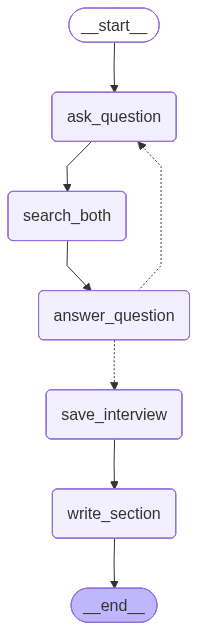

In [23]:
from textwrap import dedent
from langchain_core.messages import get_buffer_string
# 构建一个“分析师-专家”采访工作流的有向图（StateGraph），
# 流程包含：提问 → 生成搜索查询 → Web/维基检索 → 基于上下文回答 → 路由判断 → 保存采访 → 写报告小节。

search_instructions = SystemMessage(content=dedent("""
# 角色
你是一个专家系统，专长是将对话中的最后一个问题，转化为一个为技术专家量身打造的、高度精确的英文网页检索查询。

# 任务
分析提供的“分析师”与“专家”之间的对话，定位最后一个问题，并严格按照下面的格式和规则生成一个检索查询。

# 输出格式 (绝对严格)
- **唯一输出**: 你的全部输出必须是且只能是一个单行的 JSON 对象。
- **JSON 结构**: `{"search_query":"<query>"}`
- **无额外内容**: 禁止包含任何解释、说明、代码块标记(```)、前缀或后缀。
- **标准引号**: 键和值都必须使用标准的 ASCII 双引号 (")。
- **空查询**: 如果无法根据最后一个问题生成有意义的查询，则值必须为空字符串，如：`{"search_query":""}`。

# 查询生成规则
1.  **聚焦**: 查询必须且仅能基于对话的**最后一个问题**。
2.  **关键词化**: 提取问题的核心技术概念，而非完整的问句。
3.  **专业术语**: 使用具体、公认的技术术语。如果问题中提到了产品名、库名或特定的功能，必须在查询中体现。
4.  **精炼**: 查询应简明扼要，目标是高效检索，长度严格控制在15个词以内。

---
## 示例

### 正例 (必须遵循的格式)
{"search_query":"LangGraph agent workflow orchestration"}

### 反例 (必须避免的错误)
- **错误 (包含前缀)**: Here is the JSON: {"search_query":"LangGraph agent workflow orchestration"}
- **错误 (使用代码块)**: ```json\n{"search_query":"LangGraph agent workflow orchestration"}\n```
- **错误 (自然语言问句)**: {"search_query":"how to orchestrate agent workflow in LangGraph"}
"""))

answer_instructions = """你是一位专家，正在接受一名分析师的采访。

分析师关注的领域如下：{goals}。

你的目标是回答采访者提出的问题。

为回答问题，请使用以下上下文：

{context}

回答时请遵循以下准则：

1. 仅使用上下文中提供的信息。

2. 不要引入上下文之外的信息，也不要做出超出上下文明确表述的假设。

3. 上下文中的每份文档都在开头处标注了来源信息。

4. 对与某条陈述相关的内容，请在陈述旁标注其来源编号。例如，来源 1 标注为 [1]。

5. 在答案底部按顺序列出你的来源。[1] 来源 1，[2] 来源 2，等等。

6. 如果来源为：<Document source="assistant/docs/llama3_1.pdf" page="7"/>，则在参考文献处只需列出：

[1] assistant/docs/llama3_1.pdf, page 7

并且不要额外添加尖括号或 “Document source” 这类前缀描述。"""

def _numbered_context(context_list: list[str]) -> str:
    """
    为每个上下文块添加一个带括号的编号前缀：,, ...
    这个编号被专家在行内引用来源时使用。
    """
    lines = []
    for i, block in enumerate(context_list, 1): # enumerate 返回索引和值， 1 索引从 1开始
        lines.append(f"[{i}] {block}")
    return "\n\n".join(lines)

def _last_analyst_question(messages):
    """
    从消息列表中检索最后一个 name="analyst" 的 HumanMessage。
    如果未找到，则返回空字符串。
    """
    for m in reversed(messages):
        if isinstance(m, HumanMessage) and getattr(m, "name", "") == "analyst":
            return m.content
    return ""  # 后备方案

def generate_answer(state: InterviewState):
    """
    严格根据检索到的上下文生成专家的回答。
    - 构建一个嵌入了编号上下文块的系统消息。
    - 提醒模型使用标签进行行内引用，并在末尾列出来源。
    - 返回一个名为“expert”的 AIMessage，以附加到对话中。
    """
    analyst = state["analyst"]
    messages = state["messages"]
    context = state.get("context", [])
    numbered = _numbered_context(context)
    question = _last_analyst_question(messages)

    system_message = answer_instructions.format(goals=analyst.persona, context=numbered)

    prompt = HumanMessage(content=f"问题：{question}\n\n请严格依据以上编号来源作答，并在正文中使用 [1]、[2]… 引用；文末列出“来源”清单。")
    resp = llm.invoke([SystemMessage(content=system_message), prompt])

    answer_msg = AIMessage(content=resp.content, name="expert")
    return {"messages": [answer_msg]}

def save_interview(state: InterviewState):
    """ Save interviews """
    # 说明：把消息历史合并为一段文本，保存到 state["interview"]

    messages = state["messages"]
    interview = get_buffer_string(messages)

    return {"interview": interview}

def route_messages(state: InterviewState, name: str = "expert"):
    """
    决定是继续访谈还是结束：
    - 如果分析员问题的数量 < max_num_turns，则继续。
    - 如果最后一个分析员问题包含礼貌性短语，则提前停止。
    - 否则，循环以提出另一个问题。
    """
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns', 2)

    num_questions = sum(
        1 for m in messages if isinstance(m, HumanMessage) and getattr(m, "name", "") == "analyst"
    )
    if num_questions >= max_num_turns:
        return 'save_interview'

    # 安全地找到最后一个分析师问题
    last_q = None
    for m in reversed(messages):
        if isinstance(m, HumanMessage) and getattr(m, "name", "") == "analyst":
            last_q = m
            break

    return "ask_question"

section_writer_instructions = """你是一名资深技术写作者。

你的任务是基于一组来源文档，撰写一段简短且易读的报告章节。

1. 分析来源文档的内容：
- 每份来源文档的名称位于文档开头，使用 <Document 标签标注。

2. 用 Markdown 创建报告结构：
- 使用 ## 作为章节标题
- 使用 ### 作为小节标题

3. 按以下结构撰写报告：
a. 标题（##）
b. 摘要（###）
c. 来源（###）

4. 让标题与分析师的关注领域相呼应并具有吸引力：
{focus}

5. 关于“摘要”：
- 先给出与分析师关注领域相关的背景/上下文
- 强调从采访中得到的新颖、有趣或令人意外的洞见
- 不要提及采访者或专家的姓名
- 目标长度约为 1000 字
- 在正文中按使用顺序用 [1]、[2] 等与 Sources 中相对应的编号引用来源

### Sources
- 编号不要基于来源文档，从 [1] 开始重新连续编号,不要跳过数字编号
- 使用编号在 Sources 中列出你用到的来源文档
- 格式:
[1] 链接或文档名
[2] 链接或文档名

7. 合并重复来源。例如下面是错误的：
[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

正确做法是仅保留一条：

[3] https://ai.meta.com/blog/meta-llama-3-1/

8. 最终检查：
- 确保报告符合上述结构
- 标题前不要有任何前置说明
- 确保已经遵循所有指南"""

def write_section(state: InterviewState):
    """
    通过将检索到的上下文提供给 LLM，草拟一个 markdown 章节
    """
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    system_message = section_writer_instructions.format(focus=analyst.description)
    msgs = [SystemMessage(content=system_message),
            HumanMessage(content=f"请使用以下来源撰写你的章节：{context}")]

    # thinking 必须使用 stream 调用
    text = _invoke_stream_collect_text(llm_think, msgs).strip()

    return {"sections": [text]}

# -----------------------------------------------------------------------------
# 访谈子图拓扑结构
# - ask_question -> search_both -> answer_question -> (循环或 save_interview)
# - save_interview -> write_section -> END
#

from langgraph.graph import StateGraph, START, END

interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_both", search_both)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_both")
interview_builder.add_edge("search_both", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages, ['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# 为图配置持久化（记忆）与运行名称，便于可视化与调试
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [24]:
analysts[0]

Analyst(affiliation='科技创新研究院', name='张伟', role='技术架构分析师', description='关注LangGraph和LangChain在技术架构层面的差异，特别是LangGraph如何通过有状态多参与者工作流扩展LangChain的功能，以及两者在复杂应用开发中的适用场景和性能表现。')

In [25]:
from IPython.display import Markdown
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": ["现在开始任务"], "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## LangGraph vs. LangChain: Advancing Multi-Agent Workflows with Stateful Architecture

### 摘要
随着大型语言模型（LLM）应用的快速发展，组织不再满足于简单的提示-响应模式，而是寻求构建复杂、有状态的工作流，以支持多代理协调、持久内存和人在环交互。在这一背景下，LangGraph 作为一个专门框架，显著扩展了 LangChain 的功能，通过引入有状态的多参与者工作流来应对企业级 AI 解决方案的复杂需求 [1]。LangGraph 的核心创新在于其基于有向图的架构，其中节点代表状态，边代表过渡，这使得开发者能够设计确定性工作流，管理多代理系统的循环处理模式和条件路由 [2]。与 LangChain 相比，LangGraph 更专注于高级编排，而 LangChain 则提供更基础的构建块，如提示管理和简单链式操作；这种差异使得 LangGraph 在需要状态感知和迭代处理的场景中更具优势，例如在企业 AI 中处理动态工作流或实时协作任务 [3]。

一个令人惊讶的洞见是，LangGraph 通过内置状态持久化机制，允许工作流在中断后恢复，从而提高了系统的可靠性和韧性，这在 LangChain 的原始设计中并不突出 [4]。此外，LangGraph 支持多代理系统的专门化角色分配，每个代理可以专注于特定任务，并通过共享状态进行协调，这减少了开发时间并提升了应用质量，尤其是在处理边缘案例或复杂决策树时 [5]。性能方面，LangGraph 的架构支持测试环境的模拟、混沌工程测试和金丝雀部署，这些功能确保了工作流在高负载下的稳定性，而 LangChain 更适用于简单、线性的应用，其中状态管理需求较低 [6]。适用场景对比显示，LangGraph 是构建代理式 AI 系统（如自动化客服或数据分析管道）的理想选择，而 LangChain 更适合快速原型开发或基本 LLM 集成；这种分工使得开发者可以根据项目复杂度灵活选择工具，优化资源利用和性能输出 [7]。

### 来源
[1] https://www.royalcyber.com/blogs/ai-ml/langgraph-multi-agent-workflows-enterprise-ai/  
[2] https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03  
[3] https://www.scalablepath.com/machine-learning/langgraph  
[4] https://langchain-ai.github.io/langgraph/  
[5] https://blog.langchain.com/langgraph-multi-agent-workflows/  
[6] https://langchain-ai.github.io/langgraph/concepts/multi_agent/  
[7] https://medium.com/@shuv.sdr/langgraph-multi-agent-systems-mas-a30166b07691

### 并行化访谈: 通过  Send() API 对访谈进行并行化处理

In [26]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    # 主研究图共享的状态
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: List[Analyst] # 分析师提出的问题
    sections: Annotated[list, operator.add] # Send() API
    introduction: str # 最终报告的简介
    content: str # 最终报告的内容
    conclusion: str # 最终报告的结论
    final_report: str # 最终报告

In [27]:
from langgraph.types import Send

def initiate_all_interviews(state: ResearchGraphState):
    """
    这是map步骤：使用 Send API 并行启动每个采访子图。
    输入：
      - state: ResearchGraphState，期望包含以下键：
          - 'human_analyst_feedback'：可选的人工分析师反馈（存在则返回流程到创建分析师）
          - 'topic'：当前研究主题
          - 'analysts'：分析师列表（用于并行启动子图）
    返回：
      - 若存在人工反馈，则返回字符串 "create_analysts"（回到创建分析师节点）
      - 否则返回一个由 Send(...) 组成的列表，每个元素代表一次并行采访调用
    """

    # 检查是否存在人工反馈：若有，则回到创建分析师环节以便基于反馈增补或修改团队
    human_analyst_feedback = state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # 返回到 create_analysts 节点
        return "create_analysts"

    # 否则，使用 Send() API 并行启动采访子流程
    else:
        topic = state["topic"]
        # 从 state 获取 max_num_turns，如果没有则使用默认值 2
        max_num_turns = state.get("max_num_turns", 2)
        return [
            Send(
                "conduct_interview",
                {
                    "analyst": analyst,
                    "messages": [],
                    "max_num_turns": max_num_turns,
                },
            )
            for analyst in state["analysts"]
        ]


# 报告撰写器的系统 prompt
report_writer_instructions = """你是一名技术写作者，正在围绕以下总主题创作一份报告：

{topic}

你有一个分析师团队。每位分析师都完成了两件事：

1. 他们就一个具体的子主题采访了一位专家。
2. 他们将自己的发现写成了一份备忘录(memo)。

你的任务：

1. 你将获得一组来自分析师的备忘录(memo)。
2. 仔细思考每份备忘录中的洞见。
3. 将这些洞见整合为一份清晰凝练的整体总结，把所有备忘录的核心思想串联起来。
4. 将每份备忘录的要点总结为一个连贯的单一叙述。

报告的格式要求：

1.  使用 markdown 格式。
2.  报告前不添加任何前言。
3.  不要使用子标题。
4.  让你的报告以一个单一的标题头开始：`## Insights`
5.  在报告中不要提及任何分析师的名字。
6.  保留备忘录中的引用标注，这些引用会以方括号呈现，例如 [1] 或 [2]。
7.  **关于“Sources”章节的创建规则（关键指令，请严格遵守）：**
    a. 在完成 `## Insights` 报告正文的撰写之后，另起一行，创建标题为 `## Sources` 的新章节。
    b. **核心要求：** 你 **必须只列出** 那些其引用编号（如 [1], [5] 等） **在你的 `## Insights` 正文中实际出现过** 的来源。
    c. **反向约束：** 如果一个来源的编号在 `## Insights` 正文中 **没有被引用**，那么该来源 **绝对不能** 出现在最终的 `## Sources` 列表中。最终的来源列表必须是你实际引用来源的一个子集，而不是全部来源的简单合并。
    d. 确保所有列出的来源都按照编号升序排列，并且没有重复项。
8.  输出请使用中文输出。

[1] Source 1
[2] Source 2

以下是你需要据此撰写报告的分析师备忘录(memo)：

{context}"""

def write_report(state: ResearchGraphState):
    """
    汇总写作步骤：
    - 将所有 sections（分析师备忘录汇总产出）拼接成一个上下文字符串
    - 构造系统提示，要求 LLM 写出最终报告（包含合并、保留引用、Sources 列表等）
    返回：
      - {"content": report.content}
    预期 state 键：
      - 'sections': 列表（各段内容）
      - 'topic': 主题
    """
    sections = state["sections"]
    topic = state["topic"]

    # 拼接所有分段
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # 构建系统提示
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)

    # 调用 LLM：SystemMessage 提供规则，HumanMessage 发出“写报告”的指令
    report = llm.invoke([
        SystemMessage(content=system_message),
        HumanMessage(content="请基于上述备忘录撰写一份报告。")
    ])
    return {"content": report.content}


# 引言/结论写作器的系统提示
intro_conclusion_instructions = """你是一名技术写作者，正在为 {topic} 完成一份报告。

你将获得该报告的所有章节。

你的工作是撰写一段简洁有力的引言或结论。

用户会指示你撰写引言还是结论。

两部分均不要添加任何前置性前言。

目标约 100 个词：对于引言，简洁预览所有章节；对于结论，简洁回顾所有章节。

使用 markdown 格式，输出使用中文。

对于引言：请创建一个有吸引力的标题，并对该标题使用 # 作为标题头。

对于引言：请使用 ## Introduction 作为该节的节标题。

对于结论：请使用 ## Conclusion 作为该节的节标题。

以下是供你反思并据此撰写的章节内容：{formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    """
    写引言：
    - 将各 section 拼接
    - 通过 LLM 生成引言
    返回：
      - {"introduction": intro.content}
    """
    sections = state["sections"]
    topic = state["topic"]

    # 拼接所有分段
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # 构造提示
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)

    # 注意：此处传入的第一个元素是纯字符串 instructions（非 SystemMessage），
    # 具体取决于上游 LLM/客户端是否接受纯字符串作为系统/提示信息类型。
    # 为保持原逻辑不改动，仅添加说明性注释。
    intro = llm.invoke([instructions, HumanMessage(content="请撰写报告的引言")])
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    """
    写结论：
    - 将各 section 拼接
    - 通过 LLM 生成结论
    返回：
      - {"conclusion": conclusion.content}
    """
    sections = state["sections"]
    topic = state["topic"]

    # 拼接所有分段
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # 构造提示
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)

    # 同 write_introduction 的说明，这里保留原始调用方式
    conclusion = llm.invoke([instructions, HumanMessage(content="请撰写报告的结论")])
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """
    这是“reduce”步骤：收集所有部分（正文、引言、结论），组合并反思，合成最终报告。
    行为说明：
      - 从 state["content"] 中提取主体内容与 Sources 部分
      - 将引言、主体、结论合并
      - 若存在 Sources，则追加到文末
    注意：
      - content.startswith("## Insights") 的判断后，使用了 content.strip("## Insights")。
        这里 strip 会移除字符串首尾中任一出现在参数集合内的字符（而非移除完整前缀子串）。
        在极少数情况下可能导致意料外的首尾字符裁剪；本处保持原逻辑，仅作提醒。
      - 分割 Sources 使用的是精确分隔符 "\n## Sources\n"，若生成文本的换行或空格不同，可能拆分失败。
    返回：
      - {"final_report": final_report}
    """
    # 保存完整最终报告
    content = state["content"]

    # 更安全地去掉前缀 "## Insights"
    if content.startswith("## Insights"):
        content = content[len("## Insights"):].lstrip()

    # 稳健拆分 Sources（允许 header 前后有任意空行）
    parts = re.split(r"\n## Sources\s*\n", content, maxsplit=1)
    if len(parts) == 2:
        content_body, sources_raw = parts
        # 规范化 Sources：转为 bullet list
        lines = [ln.strip() for ln in sources_raw.strip().splitlines() if ln.strip()]
        sources_block = "\n".join(f"- {ln}" for ln in lines)
    else:
        content_body = content
        sources_block = None

    final_report = (
        state["introduction"].rstrip()
        + "\n\n---\n\n"
        + content_body.strip()
        + "\n\n---\n\n"
        + state["conclusion"].strip()
    )
    if sources_block:
        final_report += "\n\n## Sources\n\n" + sources_block + "\n"

    return {"final_report": final_report}
# ========== 图构建部分 ==========
# 主研究图 (报告综合)
# -----------------------------------------------------------------------------
# 这个图执行以下操作：
# - 创建分析员（带有可选的人工反馈循环）。
# - 为每个分析员并行启动一个访谈子图（Send）。
# - 访谈结束后，撰写一份合并的 markdown 格式的“洞见”报告，
#   外加引言和结论，并将所有内容合并成 final_report。
# =============================================================================
# 添加节点和边，并编译为可执行图

# 新增节点：
# - create_analysts：负责创建分析师团队
# - human_feedback：人工复核/反馈节点
# - conduct_interview：采访子图（interview_builder.compile()）
# - write_report / write_introduction / write_conclusion：写作相关节点
# - finalize_report：最终汇总节点
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report", write_report)
builder.add_node("write_introduction", write_introduction)
builder.add_node("write_conclusion", write_conclusion)
builder.add_node("finalize_report", finalize_report)

# 工作流逻辑：
# 1) START -> create_analysts -> human_feedback
# 2) 若存在人工反馈，则回到 create_analysts；否则进入 conduct_interview，并行进行采访
# 3) 采访完成后，触发写作（报告、引言、结论）
# 4) 三者完成后进入 finalize_report，再到 END
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# 编译图
# - MemorySaver：用于保存/恢复中间状态
# - interrupt_before=['human_feedback']：在进入人工反馈节点前打断，允许人工查看或编辑
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# 可视化：xray=1 会显示数据在各节点/边上的流动（若工具支持）
# display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Generating single mermaid chart


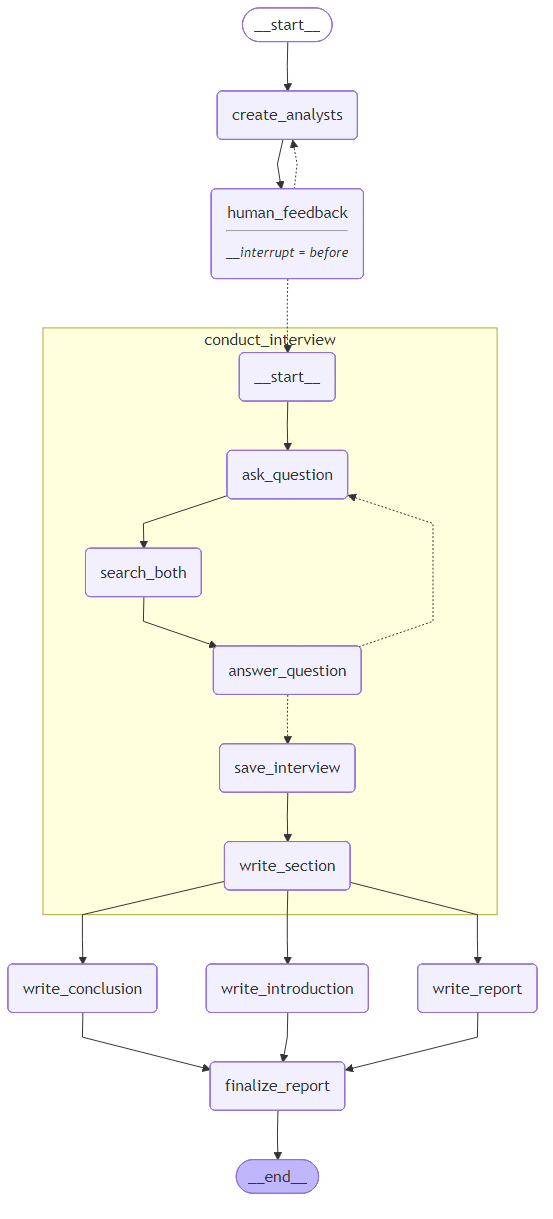

In [28]:
g = graph.get_graph(xray=1)
mmd = g.draw_mermaid(wrap_label_n_words=3)

mmd = graph.get_graph(xray=1).draw_mermaid()
with open("graph.mmd", "w", encoding="utf-8") as f:
    f.write(mmd)
!mmdc -i graph.mmd -o graph.png
from IPython.display import Image, display
display(Image(filename="graph.png"))

In [29]:
# Inputs
max_analysts = 3
topic = "采用 LangGraph 作为代理框架的好处"
thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts},
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: 张明远
Affiliation: AI系统架构研究组
Role: LangGraph架构效率分析专家
Description: 关注LangGraph在复杂AI工作流中的执行效率与资源优化，致力于通过框架特性提升系统性能与可扩展性。
--------------------------------------------------
Name: 李思涵
Affiliation: 人机协作实验室
Role: 多智能体协同交互研究员
Description: 专注于LangGraph如何促进多AI代理间的动态协作与任务分配，探索框架在模拟人类团队协作模式中的潜力。
--------------------------------------------------
Name: 王建国
Affiliation: 软件工程创新中心
Role: 开发体验与维护性分析师
Description: 研究LangGraph对开发者体验与长期系统维护的影响，强调框架在降低迭代成本与增强代码可读性方面的价值。
--------------------------------------------------


In [30]:
graph.update_state(thread, {"human_analyst_feedback":
                                "添加一个资深技术员的视角"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f091e31-19d7-6b03-8002-6bfc42b78ed5'}}

In [31]:
for event in graph.stream(None, thread, stream_mode="values"): # 后三个为更新后的 analyst
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: 张明远
Affiliation: AI系统架构研究组
Role: LangGraph架构效率分析专家
Description: 关注LangGraph在复杂AI工作流中的执行效率与资源优化，致力于通过框架特性提升系统性能与可扩展性。
--------------------------------------------------
Name: 李思涵
Affiliation: 人机协作实验室
Role: 多智能体协同交互研究员
Description: 专注于LangGraph如何促进多AI代理间的动态协作与任务分配，探索框架在模拟人类团队协作模式中的潜力。
--------------------------------------------------
Name: 王建国
Affiliation: 软件工程创新中心
Role: 开发体验与维护性分析师
Description: 研究LangGraph对开发者体验与长期系统维护的影响，强调框架在降低迭代成本与增强代码可读性方面的价值。
--------------------------------------------------
Name: 陈明
Affiliation: LangChain 技术团队
Role: 资深技术架构师
Description: 关注 LangGraph 如何通过有向图结构优化多代理协作，提升复杂任务处理效率与可维护性，同时担忧框架的集成复杂性与学习曲线。
--------------------------------------------------
Name: 李思
Affiliation: AI 应用开发公司
Role: 首席开发工程师
Description: 专注于 LangGraph 在动态工作流编排和状态管理方面的优势，担忧框架对资源消耗和部署灵活性的影响，追求高效、可扩展的代理解决方案。
--------------------------------------------------
Name: 王远
Affiliation: 技术创新研究实验室
Role: 研究主管
Description: 探索 LangGraph 在代理决策透明度和错误恢复机制上的价值，关注其长期可演进性与社区生态支持，致力于推动可靠且适应性强的 AI 系统框架。
---

In [32]:
graph.update_state(thread, {"human_analyst_feedback":
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f091e31-dae0-65b7-8004-d2cb6821b8bf'}}

In [33]:
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_conclusion
--Node--
write_introduction
--Node--
write_report
--Node--
finalize_report


In [34]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# LangGraph：构建下一代智能代理的协作与编排框架

## Introduction

本报告探讨了采用 LangGraph 作为代理框架的显著优势。首先，报告分析了 LangGraph 如何通过有向图架构增强多代理协作，优化状态管理并提升处理效率。随后，深入研究了其作为动态工作流编排引擎的能力，通过状态化智能支持实时决策和自适应流程控制。最后，报告评估了 LangGraph 在提升决策透明度与错误恢复方面的价值，强调了其生产就绪特性和强大的社区支持。这些章节共同展示了 LangGraph 如何为复杂、可扩展的代理系统提供

---

采用 LangGraph 作为代理框架的核心优势在于其通过有向图架构重新定义了多代理系统的协作、编排与可靠性。该框架将代理交互建模为图形结构，显著提升了复杂任务的处理效率和系统的整体可维护性 [2]。与依赖静态有向无环图（DAG）的传统工作流编排器（如 Apache Airflow）不同，LangGraph 独特地支持循环结构，实现了动态、迭代的代理交互，这对于处理不确定或持续演化的任务至关重要 [11]。这种动态性源于其内置的有限状态机（FSM）模型，能够根据实时输入和输出进行状态转换，从而实现代理式推理和内存更新，这是传统工具所缺乏的关键能力 [1]。

在性能与资源效率方面，LangGraph 展现出显著优势。其图基础架构通过集中化管理共享状态，降低了代码复杂性，使开发者更易于调试和扩展系统 [8]。状态集中化还减少了平均每轮通信开销，从而优化了吞吐量，在批量查询处理或科学工作流等场景中尤其明显 [10]。与 Airflow 等需要强大基础设施来处理内存密集型扩展的方案相比，LangGraph 的架构更轻量级，专为 LLM 用例量身定制，在资源受限的环境中减少了开销 [1][2]。然而，管理状态转换和内存持久化会带来可衡量的性能成本，这可能影响高吞吐量场景下的扩展性，但该框架与 Kubernetes 等容器编排平台的集成简化了部署和资源调整，有效缓解了此类问题 [10]。

LangGraph 在确保决策透明度和实现强大错误恢复方面同样表现出色。其人性化循环（human-in-the-loop）功能允许开发者实时监控和调节代理行为，防止偏离预期路径，并通过内置的审核与质量控制工具支持人工干预，显著提升了生产环境中的决策透明度 [1]。状态管理机制是简化错误恢复的核心，代理可以维护跨交互的状态，并通过检查点实现状态持久化，使得在故障发生时能够从之前的状态恢复，极大增强了系统的耐用性和可靠性 [10]。此外，图基础设计允许对代理工作流进行可视化，使开发者能够直观地理解和调试决策过程，进一步促进了透明度 [3]。

该框架的生产就绪特性，包括其对控制、耐用性和核心特性的强调，使其非常适合真实世界系统 [2]。通过模块化组件，开发者可以轻松集成预构建工具和钩子（hooks），加速开发过程而不牺牲可控性，例如使用 `create_react_agent` 函数快速设置标准的推理、工具使用和响应流 [3][4]。强大的社区生态进一步推动了其成功，丰富的教程、案例研究和社区驱动的资源（如在 Reddit 等平台上的讨论）分享了最佳实践，提供了真实世界的反馈，并增强了框架在构建多代理系统或代理式 RAG 等复杂应用时的适应性和可靠性 [3][10]。

---

## Conclusion

LangGraph 通过其基于有向图的架构，为构建高效、可靠的多代理系统提供了强有力的解决方案。本报告重点阐述了其在提升多代理协作效率、实现动态工作流编排，以及增强决策透明度与错误恢复能力方面的核心优势。该框架通过集中化状态管理、支持循环交互结构以及简化集成与部署，显著降低了系统复杂性和资源开销。尽管存在一定的学习曲线和性能权衡，但其灵活性、可扩展性以及强大的社区支持，使其成为开发复杂、生产级AI应用的理想选择。LangGraph不仅代表了多代理技术的重要演进，更为未来智能系统的设计与实现奠定了

## Sources

- [1] https://sai-tai.com/ai/agentic-system/langraph-vs-other-products/
- [2] https://www.linkedin.com/pulse/multi-agent-systems-using-langgraph-dileep-kumar-pandiya-f6mme
- [3] https://lekha-bhan88.medium.com/how-i-used-langgraphs-prebuilt-agent-and-visualised-the-agent-graph-22861f137e18
- [8] https://latenode.com/blog/langchain-vs-langgraph-complete-comparison-guide-for-developers
- [10] https://arxiv.org/html/2412.05449v1
- [11] https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03
